In [2]:
import sys
import math
import numpy as np
from numpy import pi, sqrt, inf, log
from ecell4 import *

L = 100
voxel_radius = 0.005
D = 1
rng = GSLRandomNumberGenerator()
rng.seed(1)
#if len(sys.argv) > 1:
#    rng.seed(int(sys.argv[1]))

w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxel_radius, Integer3(3, 3, 3), rng)

def singlerunA(dt, Pacc,alpha):
    assert Pacc*alpha  <= 1
    assert alpha<=1

    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt*alpha
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc * alpha >= w.rng().uniform(0, 1):
                return t
        elif alpha >= w.rng().uniform(0, 1):
            coord2 = newcoord
        t += dt
        nsteps += 1
    return False

def singlerun(dt, Pacc):
    assert Pacc<= 1
    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc >= w.rng().uniform(0, 1):
                return t
        else:
            coord2 = newcoord
        t += dt
        nsteps += 1
    return False

        
kD = 4 * pi * (2 * voxel_radius) * D
ka_factor = 0.1  # 100.0
ka = kD * ka_factor
r0=0.256318
Pacc = (1./r0-1)*ka_factor#ka / (6 * sqrt(2) * D * voxel_radius)
dt = (4 * voxel_radius * voxel_radius) / (6 * D)
maxstep= 10000
ntrials = 100000
print Pacc
if Pacc<=1:
    res = [singlerun(dt, Pacc) for _ in range(ntrials)]
else:    
    res = [singlerunA(dt, Pacc,0.1/Pacc) for _ in range(ntrials)]
times = np.array([i for i in res if i != False])
#print float(len(times))/ntrials
#print float(len(times[times<dt]))/ntrials

0.290140372506


KeyboardInterrupt: 

In [50]:
def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def f(t):
    x = np.sqrt(t)
    return (1./math.pi**0.5 /x - phix(x))

def theory(c):
    R = 2*voxel_radius
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)
    tau = np.logspace(-5,math.log10(1e-1/tmol),100)
    #tau = np.logspace(0,math.log10(1e-1/tmol),100)
    t = tau*tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(t,f(tau)*Nfactor,'-',c=c,label='Theory $k_a/k_D='+str(ka_factor)+'$')
    #plt.plot([tmol]*10, np.logspace(-10,4,10),'--')
    return #t,Ptotal*f(tau)

def theorykaf10(c):
    voxel_radius = 0.005
    D = 1
    kD = 4 * pi * (2 * voxel_radius) * D
    R = 2*voxel_radius
    ka_factor = 10  # 100.0
    ka = kD * ka_factor    
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)
    tau = np.logspace(-3,math.log10(1e-1/tmol),100)
    #tau = np.logspace(0,math.log10(1e-1/tmol),100)
    t = tau*tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(t,f(tau)*Nfactor,'-',c=c,label='Theory $k_a/k_D='+str(ka_factor)+'$')
    #plt.plot([tmol]*10, np.logspace(-10,4,10),'--')
    return #t,Ptotal*f(tau)

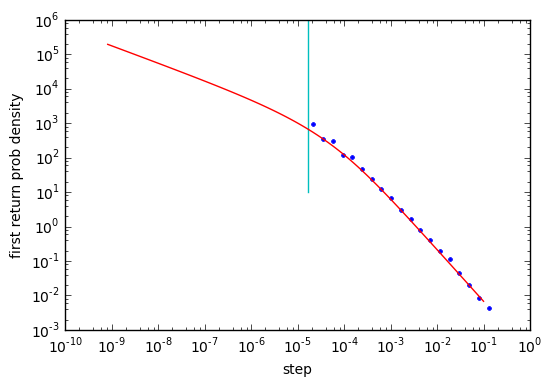

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
hist, bin_edges = np.histogram(times,bins=np.logspace(np.log10(min(times)),np.log10(max(times)),20))
tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
binwid = -(bin_edges[:-1]-bin_edges[1:])
ft = np.array([float(h)/ntrials/b for h,b in zip(hist,binwid)])
plt.loglog(tt,ft,'.')
z = lambda x: 1e-4*(x**-1.5) #t^(-0.5)
w = lambda x: 1e2*(x**-0.5) #t^(-0.5)
#plt.plot(np.logspace(-5,-2,50),z(np.logspace(-5,-2,50)),label='p ~ t^-1.5')
#plt.plot(np.logspace(-8,-5,50),w(np.logspace(-8,-5,50)),'r',label='p ~ t^-0.5')
prange = np.logspace(1,6,10)
plt.plot([dt]*len(prange),prange,'c')
plt.xlabel('step')
plt.ylabel('first return prob density')
#totalsum = sum(ft*binwid)
theory('r')
plt.legend()


In [14]:
dat = np.loadtxt("rebinding_prob_kfac10",delimiter=',')
t10 = dat[:,0]
pd10 = dat[:,1]

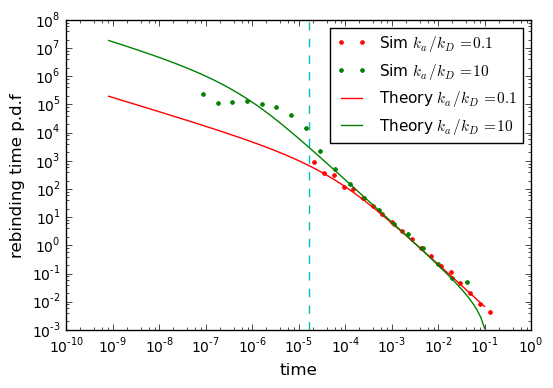

In [51]:
plt.plot(tt,ft,'r.',label='Sim $k_a/k_D=0.1$')
plt.plot(t10,pd10,'g.',label='Sim $k_a/k_D=10$')
theory('r')
theorykaf10('g')
prange = np.logspace(-3,8,10)
plt.plot([dt]*len(prange),prange,'c--')
plt.legend(loc='best',fontsize=11)
plt.xlabel('time',fontsize=12)
plt.ylabel('rebinding time p.d.f',fontsize=12)
plt.savefig("figure/rebinding_prob_2_spa_gfrd.png",format='png',dpi=300)    

In [144]:
from scipy import special
voxel_radius=0.005
D=1
tm = (4 * voxel_radius * voxel_radius) / (6 * D)

def phix(x):
    return special.erfcx(x)
    #return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def f(t):
    x = t**0.5
    return (1./math.pi**0.5 /x - phix(x))

def theorykaf(kfac,tt,c):
    kD = 4 * np.pi * (2 * voxel_radius) * D
    R = 2*voxel_radius
    ka = kD * kfac
    tmol = R*R/D/(1+ka/kD)**2
    #Ptotal = ka/(ka+kD)
    tau = tt/tmol
    #t = tau*tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(tt,f(tau)*Nfactor,'-',c=c,label='Theory $k_a/k_D='+str(kfac)+'$')
    #plt.plot([tmol]*10, np.logspace(-10,4,10),'--')
    return #t,Ptotal*f(tau)

def gethist(times,nt):
    hist, bin_edges = np.histogram(times,bins=np.logspace(np.log10(min(times)),np.log10(max(times)),30))
    tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
    binwid = -(bin_edges[:-1]-bin_edges[1:])
    ft = np.array([float(h)/nt/b for h,b in zip(hist,binwid)])
    return tt,ft

kfac0.1trial700000 trials 700000
preb 0.0920728571429 theory 0.0926296515259
kfac1.0trial400000 trials 400000
preb 0.50436 theory 0.505160742979
kfac100.0trial800000 trials 800000
preb 0.99026375 theory 0.990299345326


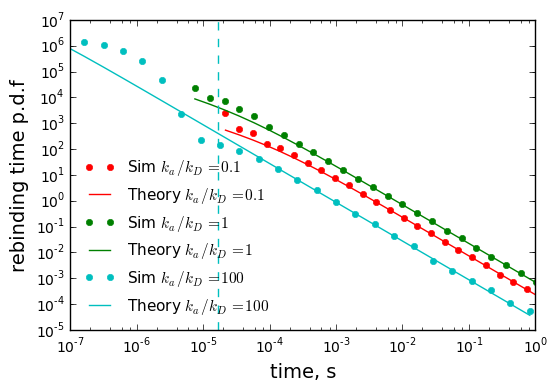

In [148]:
import sys
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
sz=10
names = ["kfac0.1trial700000","kfac1.0trial400000","kfac100.0trial800000"]
cs=['r','g','c']
kfacs=[0.1,1,100]
voxel_radius=0.005
D=1
kD = 4 * np.pi * (2 * voxel_radius) * D
R0=0.256318

for i in range(3):
    name = names[i]
    c=cs[i]
    kfac=kfacs[i]
    ka = kD * kfac
    Pacc = ka / (6 * 2**0.5 * D * voxel_radius)
    times = np.loadtxt(name,delimiter=',')
    nt = int(name[-6:])
    print name,'trials',nt
    print 'preb',float(len(times))/nt,'theory',Pacc/(Pacc+ 1./R0 -1)
    dt= np.unique(np.sort(times))[1]
    times+=dt
    tt,ft=gethist(times,nt)
    plt.plot(tt[:-4],ft[:-4],c+'.',label='Sim $k_a/k_D='+str(kfac)+'$',markersize=sz)
#for kfac,c in zip(kfacs,cs):
    theorykaf(kfac,tt[:-4],c)
prange = np.logspace(-5,7,10)
plt.plot([tm]*len(prange),prange,'c--')
plt.legend(loc='best',fontsize=11,frameon=False)
plt.xlabel('time, s',fontsize=14)
plt.ylabel('rebinding time p.d.f',fontsize=14)
plt.xlim([1e-7,1])
plt.ylim(1e-5,1e7)    
plt.savefig("figure/rebinding_sep.png",format='png',dpi=300)    

In [133]:
def gethist2(ret,norun): #to get rxn fraction for each discrete t
    uq,uqcnt = np.unique(ret,return_counts=True)
    freq = [float(i)/norun for i in uqcnt]
    for i,j in zip(uq,uqcnt): print i,float(j)/norun
    #plt.loglog(freq,'.')
    
times = np.loadtxt("kfac100.0trial800000",delimiter=',')
gethist2(times,800000)

0.0 0.08311
5.62697697598e-08 0.0761825
1.1253953952e-07 0.06951625
1.68809309279e-07 0.0637825
2.25079079039e-07 0.05880625
2.81348848799e-07 0.05330625
3.37618618559e-07 0.04896125
3.93888388319e-07 0.04489625
4.50158158079e-07 0.04091
5.06427927838e-07 0.03721375
5.62697697598e-07 0.0338225
6.18967467358e-07 0.03166875
6.75237237118e-07 0.02892
7.31507006878e-07 0.02607875
7.87776776637e-07 0.02401
8.44046546397e-07 0.0219675
9.00316316157e-07 0.01986125
9.56586085917e-07 0.01856125
1.01285585568e-06 0.01663
1.06912562544e-06 0.01543375
1.1253953952e-06 0.01396875
1.18166516496e-06 0.012645
1.23793493472e-06 0.01171875
1.29420470448e-06 0.01062
1.35047447424e-06 0.0098675
1.406744244e-06 0.0088825
1.46301401376e-06 0.0081375
1.51928378352e-06 0.00757875
1.57555355327e-06 0.00695375
1.63182332303e-06 0.00624375
1.68809309279e-06 0.0056625
1.74436286255e-06 0.00528625
1.80063263231e-06 0.0047825
1.85690240207e-06 0.004335
1.91317217183e-06 0.00406375
1.96944194159e-06 0.0035325
2.0257

In [142]:
r=0.005
D=1
kd=4*3.14*2*r*D
ka=100*kd
P=ka/6/2**0.5/D/r
a=1./P

In [143]:
P*a/12

0.08333333333333333

In [138]:
((1-a)*11/12 +a/3)/12

0.07622468548296048